# Neural Collaborative Filtering

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import math

from tensorflow import keras
from tensorflow.keras import Model
from tensorflow.keras.layers import Input, Dense, Concatenate, Embedding, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import Sequence
from tensorflow.keras.regularizers import l2, l1, l1_l2
from tensorflow.keras.initializers import RandomUniform, he_normal, he_uniform
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import plot_model
from IPython.display import SVG
from tensorflow.keras.utils import model_to_dot

In [2]:
# TODO could try different thresholds for played
train = pd.read_csv("data\\train-plays.csv").drop(columns=["norm_amount", "amount"])
test = pd.read_csv("data\\test-plays.csv").drop(columns=["norm_amount", "amount"])
game_coding = pd.read_csv("data\\game-coding.csv")

## Format training data

In [3]:
train['played'] = 1

In [4]:
rand_users = np.random.randint(0, train.user_id.unique().size, train.shape[0] * 10)
rand_games = np.random.randint(0, train.game_id.unique().size, train.shape[0] * 10)
neg_train = pd.DataFrame({"user_id":rand_users, "game_id":rand_games})
neg_train

,user_id,game_id
0,652,455
1,420,306
2,597,963
3,511,728
4,673,700
...,...,...
364465,733,969
364466,713,749
364467,173,813
364468,518,787


In [5]:
train = train.append(neg_train).drop_duplicates(subset=['game_id', 'user_id'])
train.played = np.where(train.played != 1, 0, 1)
train = train.sample(frac=1.0)
train

,game_id,user_id,played
361943,850,1080,0
86186,635,566,0
5118,917,515,0
198612,978,659,0
163770,164,370,0
...,...,...,...
239657,873,107,0
75595,903,823,0
238649,469,532,0
179875,34,547,0


In [6]:
print(train[train.played == 0].shape[0]/train.shape[0])
print(train[train.played == 1].shape[0]/train.shape[0])

0.8932775422239921
0.10672245777600788


In [7]:
# check to make sure didn't introduce conflicting neg training instances
train.groupby(by=['user_id']).agg({'game_id':lambda x: x.unique().size == x.size})['game_id'].all()

True

## Neural Network Construction

In [44]:
# number of latent factors
n_latent_factors = 16

In [45]:
# game input and embedding
game_input = keras.layers.Input(shape=[1], name='Game')
game_embedding = keras.layers.Embedding(train.game_id.unique().size, n_latent_factors,
                                          embeddings_regularizer=l2(1e-6), 
                                          embeddings_constraint='NonNeg',
                                          name='Game-Embedding')(game_input)
game_vec = keras.layers.Flatten(name='FlattenGames')(game_embedding)

In [46]:
# user input and embedding
user_input = keras.layers.Input(shape=[1], name='User')
user_embedding = keras.layers.Embedding(train.user_id.unique().size, n_latent_factors,
                                          embeddings_regularizer=l2(1e-6), 
                                          embeddings_constraint='NonNeg',
                                          name='User-Embedding')(user_input)
user_vec = keras.layers.Flatten(name='FlattenUsers')(user_embedding)

In [47]:
# Multi-Layer Perceptron part of model
layer = keras.layers.concatenate([game_vec, user_vec], name="UserGames")
for i in [4, 2, 1, 0.5, 0.25, 0]:
  if i == 0:
    mlp_output = Dense(1, activation='relu', kernel_initializer='he_uniform')(layer)
  else:
    layer = Dense(math.floor(n_latent_factors * i), activation='relu', 
                kernel_initializer='he_uniform', 
                activity_regularizer=l2(0.01))(layer)
    if i == 4:
      layer = BatchNormalization()(layer)
    layer = Dropout(0.2)(layer)
 
# mlp = Model(inputs=[user_input, game_input], outputs=layer)
# mlp.compile(optimizer='adam', loss='binary_crossentropy', metrics=['binary_accuracy'])

In [48]:
# Generalized Matrix Factorization part of model
prod = keras.layers.dot([user_vec, user_vec], axes=1, name='DotProduct')
# gmf = Model(inputs=[user_input, game_input], outputs=prod)
# gmf.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae', 'mse'])

In [49]:
# Combining MLP and GMF parts of the model
combined_outputs = keras.layers.concatenate([mlp_output, prod])
ncf_output = Dense(1, activation='sigmoid', kernel_initializer='he_uniform')(combined_outputs)
ncf = Model(inputs=[user_input, game_input], outputs=ncf_output)
ncf.compile(optimizer='adam', loss='binary_crossentropy', metrics=['binary_accuracy'])

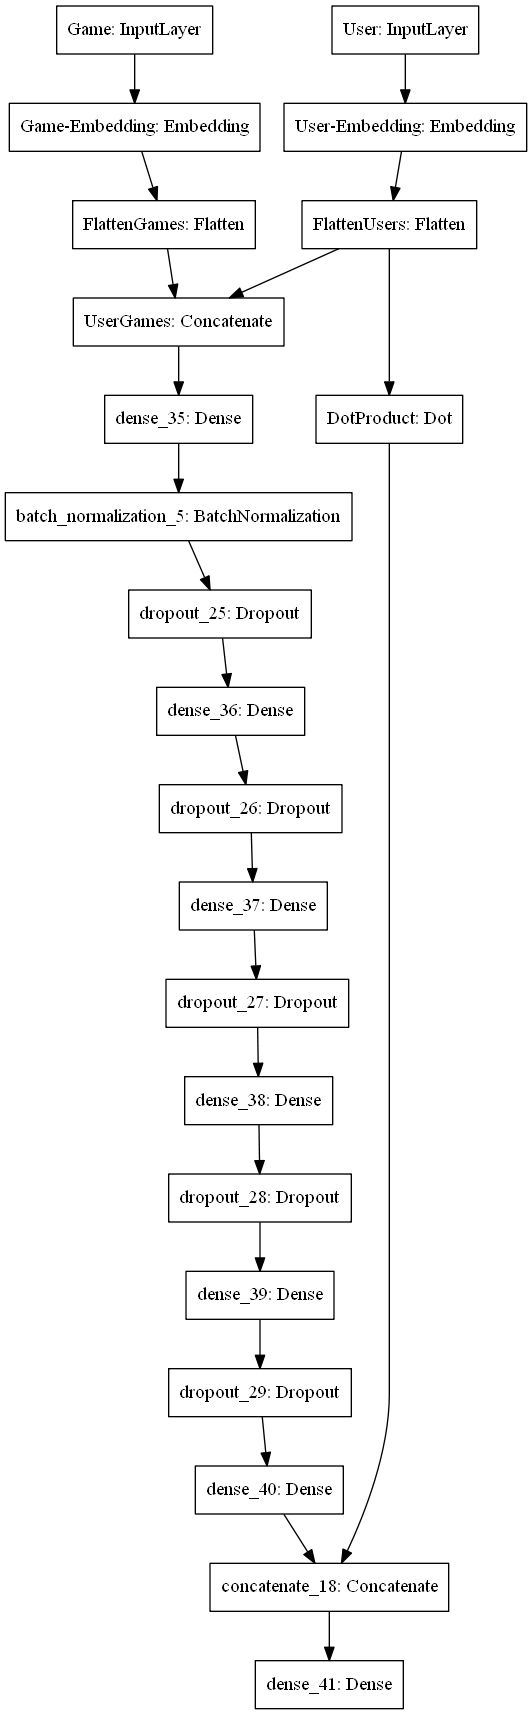

In [50]:
plot_model(ncf)

## Model Training

In [51]:
# train mlp
# early_stop = keras.callbacks.EarlyStopping(monitor='binary_accuracy', min_delta = 0.0001, patience=10)
# mlp_history = mlp.fit([train.user_id, train.game_id], train.played, batch_size=256, epochs=1, callbacks=[early_stop])
# pd.Series(mlp_history.history['loss']).plot(logy=True)
# plt.xlabel("Epoch")
# plt.ylabel("Training Error")

In [52]:
# train gmf
# gmf_history = gmf.fit([train.user_id, train.game_id], train.played, batch_size=256, epochs=1)
# pd.Series(gmf_history.history['loss']).plot(logy=True)
# plt.xlabel("Epoch")
# plt.ylabel("Training Error")

In [158]:
# train ncf
early_stop = keras.callbacks.EarlyStopping(monitor='binary_accuracy', min_delta = 0.0001, patience=10)
ncf_history = ncf.fit([user_input, game_input], train.played, batch_size=256, epochs=100, callbacks=early_stop)
pd.Series(ncf_history.history['loss']).plot(logy=True)
plt.xlabel("Epoch")
plt.ylabel("Training Error")

TypeError: int() argument must be a string, a bytes-like object or a number, not 'NoneType'

## Model Analysis

In [39]:
def recommend_game(uid, model, n=10):
    uid_array = np.repeat(uid, game_coding.game_id.size)
    recs = np.ndarray.flatten(model.predict([uid_array, game_coding.game_id]))
    recs_df =  pd.DataFrame({'game_id':game_coding.game_id, 'rec_confidence':recs})
    return set(recs_df.sort_values(by='rec_confidence', ascending=False).head(10).game_id)

In [41]:
test['recommended'] = np.vectorize(recommend_game)(test.user_id.unique(), model)

In [50]:
test

,game_id,user_id,played,recommended
0,16,0,1,"{1025, 450, 771, 932, 585, 714, 457, 17, 952, ..."
1,35,1,1,"{37, 169, 782, 943, 1040, 113, 1013, 469, 441,..."
2,203,2,1,"{1025, 611, 782, 943, 562, 147, 1013, 23, 509,..."
3,265,3,1,"{36, 542, 839, 1036, 717, 431, 883, 91, 990, 95}"
4,286,4,1,"{1, 782, 1040, 562, 888, 1013, 983, 952, 858, ..."
...,...,...,...,...
1155,584,1155,1,"{1025, 99, 100, 3, 622, 943, 760, 374, 855, 982}"
1156,656,1156,1,"{448, 129, 39, 266, 782, 943, 431, 947, 95, 159}"
1157,973,1157,1,"{611, 782, 943, 1040, 562, 947, 659, 151, 952,..."
1158,901,1158,1,"{3, 424, 782, 270, 176, 465, 659, 151, 952, 1022}"


In [58]:
np.vectorize(lambda gid, recs: 1 if gid in recs else 0)(test.game_id, test.recommended).sum() / test.user_id.unique().size

0.011206896551724138